# Abstract

Aim of the notebook is to discover how to develop a convolutional neural network for handwritten digit classification from scratch. Upon completion, we will understand:

1. How to develop a test harness to develop a robust evaluation of a model and establish a baseline of performance for a classification task.
2. How to explore extensions to a baseline model to improve learning and model capacity.
3. How to develop a finalized model, evaluate the performance of the final model, and use it to make predictions on new images.

In [1]:
from numpy import mean
from numpy import std
from matplotlib import pyplot as plt
from sklearn.model_selection import KFold
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.optimizers import SGD

In [2]:
def load_dataset():
  # load dataset
  (trainX, trainY), (testX, testY) = mnist.load_data()
  # reshape dataset to have a single channel
  trainX = trainX.reshape((trainX.shape[0], 28, 28, 1))
  testX = testX.reshape((testX.shape[0], 28, 28, 1))
  # one hot encode target values
  trainY = to_categorical(trainY)
  testY = to_categorical(testY)
  return trainX, trainY, testX, testY

11490434/11490434 [==============================] - 1s 0us/step
Train: X=(60000, 28, 28, 1), y=(60000, 10)
Test: X=(10000, 28, 28, 1), y=(10000, 10)


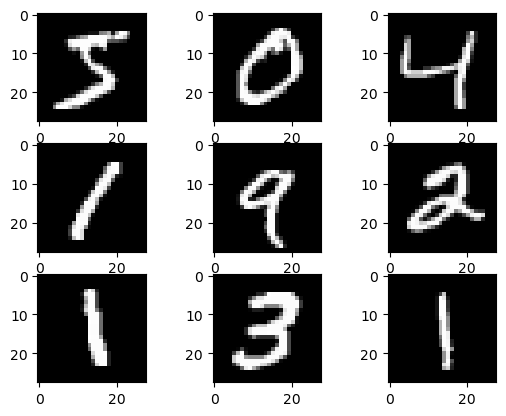

In [3]:
trainX, trainY, testX, testY = load_dataset()
print('Train: X=%s, y=%s' % (trainX.shape, trainY.shape))
print('Test: X=%s, y=%s' % (testX.shape, testY.shape))
# plot first few images
for i in range(9):
 # define subplot
 plt.subplot(330 + 1 + i)
 # plot raw pixel data
 plt.imshow(trainX[i], cmap=plt.get_cmap('gray'))
# show the figure
plt.show()

# Normalizing Pixels

1. We know that the pixel values for each image in the dataset are unsigned integers in the range between black and white, or 0 and 255.

2. We do not know the best way to scale the pixel values for modeling, but we know that some scaling will be required.

3. A good starting point is to normalize the pixel values of grayscale images, e.g. rescale them to the range [0,1]. This involves first converting the data type from unsigned integers to floats, then dividing the pixel values by the maximum value.

In [4]:
def prep_pixels(train, test):
  # convert from integers to floats
  train_norm = train.astype('float32')
  test_norm = test.astype('float32')
  # normalize to range 0-1
  train_norm = train_norm / 255.0
  test_norm = test_norm / 255.0
  # return normalized images
  return train_norm, test_norm

# Model Definition

>The model has two main aspects:<br>
a. Feature extraction comprised of convolutional and pooling layers<br>
b. Classifier backend that will make a prediction.

>For the convolutional front-end, we can start with a single convolutional layer with a small filter size (3,3) and a modest number of filters (32) followed by a max pooling layer. The filter maps can then be flattened to provide features to the classifier.

>Given that the problem is a multi-class classification task, we know that we will require an output layer with 10 nodes in order to predict the probability distribution of an image belonging to each of the 10 classes.
>We will use a conservative configuration for the stochastic gradient descent optimizer with a learning rate of 0.01 and a momentum of 0.9. The categorical cross-entropy loss function will be optimized, suitable for multi-class classification, and we will monitor the classification accuracy metric, which is appropriate given we have the same number of examples in each of the 10 classes.

In [5]:
def define_model():
  model = Sequential()
  model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(28, 28, 1)))
  model.add(MaxPooling2D((2, 2)))
  model.add(Flatten())
  model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
  model.add(Dense(10, activation='softmax'))
  # compile model
  opt = SGD(learning_rate=0.01, momentum=0.9)
  model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
  return model

# Model Evaluation

1. The model will be evaluated using five-fold cross-validation. The value of k=5 was chosen to provide a baseline for both repeated evaluation and to not be so large as to require a long running time. Each test set will be 20% of the training dataset, or about 12,000 examples, close to the size of the actual test set for this problem.

1. The training dataset is shuffled prior to being split, and the sample shuffling is performed each time, so that any model we evaluate will have the same train and test datasets in each fold, providing an apples-to-apples comparison between models.

3. We will train the baseline model for a modest 10 training epochs with a default batch size of 32 examples. The test set for each fold will be used to evaluate the model both during each epoch of the training run, so that we can later create learning curves, and at the end of the run, so that we can estimate the performance of the model. As such, we will keep track of the resulting history from each run, as well as the classification accuracy of the fold.

In [6]:
def evaluate_model(dataX, dataY, n_folds=5):
  scores, histories = list(), list()
  # prepare cross validation
  kfold = KFold(n_folds, shuffle=True, random_state=1)
  # enumerate splits
  for train_ix, test_ix in kfold.split(dataX):
    # define model
    model = define_model()
    # select rows for train and test
    trainX, trainY, testX, testY = dataX[train_ix], dataY[train_ix], dataX[test_ix], dataY[test_ix]
    # fit model
    history = model.fit(trainX, trainY, epochs=10, batch_size=32, validation_data=(testX, testY), verbose=0)
    # evaluate model
    _, acc = model.evaluate(testX, testY, verbose=0)
    print('> %.3f' % (acc * 100.0))
    # stores scores
    scores.append(acc)
    histories.append(history)
  return scores, histories

# Diagnostics

>There are two key aspects to present:<br>
a. Diagnostics of the learning behavior of the model during training<br>
b. Estimation of the model performance. These can be implemented using separate functions.

>First, the diagnostics involve creating a line plot showing model performance on the train and test set during each fold of the k-fold cross-validation. These plots are valuable for getting an idea of whether a model is overfitting, underfitting, or has a good fit for the dataset.

>We will create a single figure with two subplots, one for loss and one for accuracy. Blue lines will indicate model performance on the training dataset and orange lines will indicate performance on the hold out test dataset. The summarize_diagnostics() function below creates and shows this plot given the collected training histories.

In [7]:
def summarize_diagnostics(histories):
  for i in range(len(histories)):
    # plot loss
    plt.subplot(2, 1, 1)
    plt.title('Cross Entropy Loss')
    plt.plot(histories[i].history['loss'], color='blue', label='train')
    plt.plot(histories[i].history['val_loss'], color='orange', label='test')
    # plot accuracy
    plt.subplot(2, 1, 2)
    plt.title('Classification Accuracy')
    plt.plot(histories[i].history['accuracy'], color='blue', label='train')
    plt.plot(histories[i].history['val_accuracy'], color='orange', label='test')
    plt.show()

# Performance

>Next, the classification accuracy scores collected during each fold can be summarized by calculating the mean and standard deviation. This provides an estimate of the average expected performance of the model trained on this dataset, with an estimate of the average variance in the mean. We will also summarize the distribution of scores by creating and showing a box and whisker plot.

In [8]:
def summarize_performance(scores):
  # print summary
  print('Accuracy: mean=%.3f std=%.3f, n=%d' % (mean(scores)*100, std(scores)*100, len(scores)))
  # box and whisker plots of results
  plt.boxplot(scores)
  plt.show()

In [9]:
# load dataset
trainX, trainY, testX, testY = load_dataset()
# prepare pixel data
trainX, testX = prep_pixels(trainX, testX)
# evaluate model
scores, histories = evaluate_model(trainX, trainY)

> 98.550
> 98.717
> 98.583
> 98.792
> 98.858


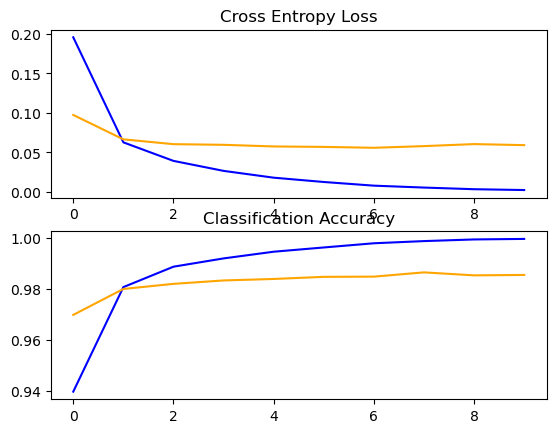

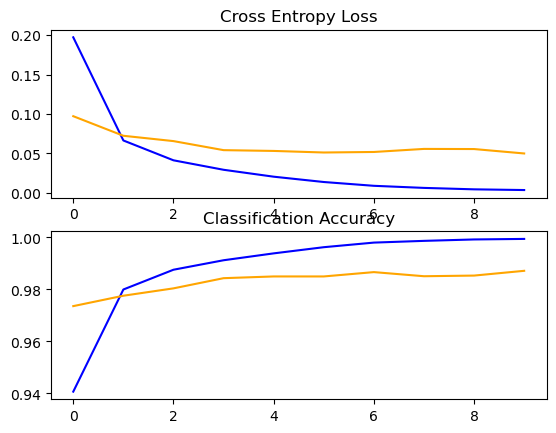

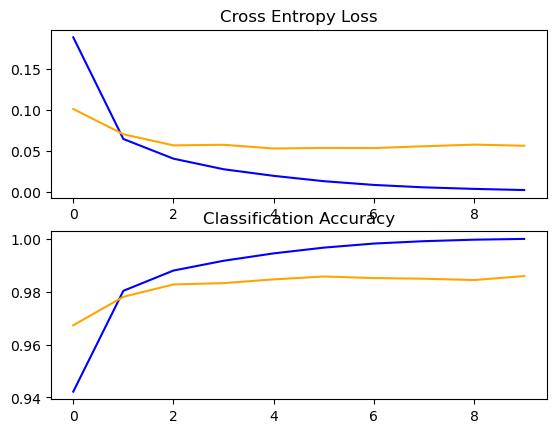

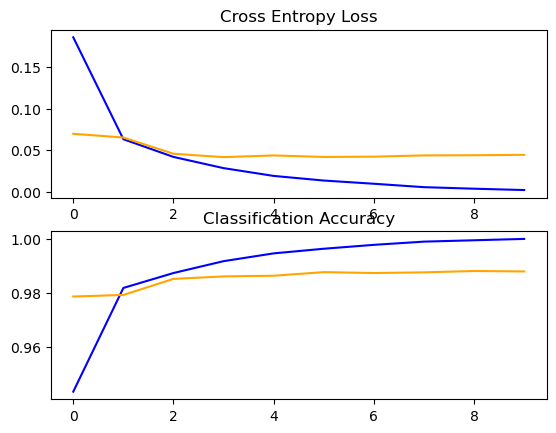

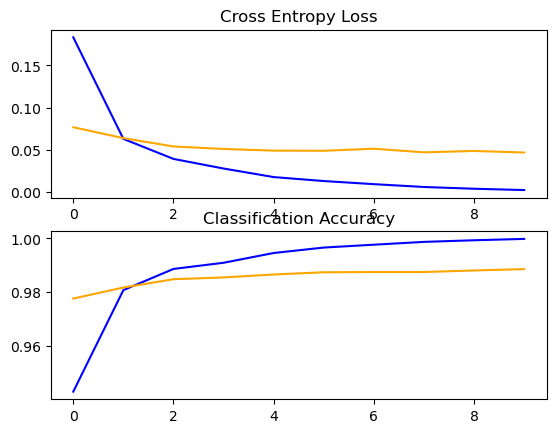

In [10]:
# learning curves
summarize_diagnostics(histories)

Accuracy: mean=98.700 std=0.118, n=5


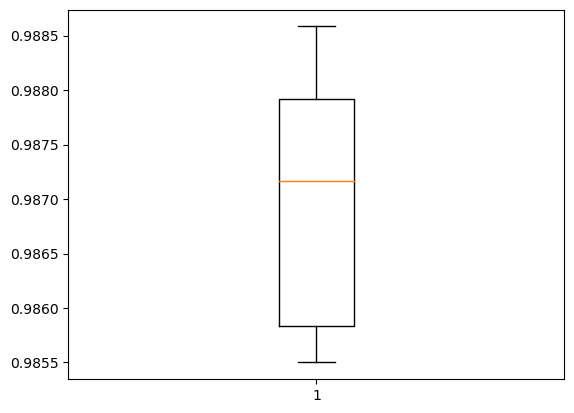

In [11]:
# summarize estimated performance
summarize_performance(scores)

# Conclusion
Using the complex MNIST dataset, which contains 10 digits, this study demonstrates the promise of Convolutional Neural Network (CNN) based approaches for automated character recognition systems, notably for typography categorization. To deal with the heterogeneity in the dataset, the suggested model employs a deep CNN architecture with numerous convolutional and pooling layers as well as data augmentation approaches. This study surpasses previous state-of-the-art techniques and offers a substantial development in the field with a remarkable accuracy of almost 98% on the test set. The outcomes show how well CNNs perform in practical applications and encourage further study to create better machine learning models for difficult data analysis.

# Refernces

1. Tensorflow and Keras documentation
2. Kaggle [Notebook](https://www.kaggle.com/nikbearbrown/tmnist-alphabet-94-characters/)
3. [TMNIST](https://www.kaggle.com/nimishmagre/tmnist-typeface-mnist) - Database of Typeface-based digits

# MIT License

Copyright (c) 2019 Wok

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.